In [1]:
! pip install 'git+https://github.com/Maluuba/nlg-eval.git@master'

  Cloning https://github.com/Maluuba/nlg-eval.git (to revision master) to /tmp/pip-req-build-0or99tpk
  Running command git clone -q https://github.com/Maluuba/nlg-eval.git /tmp/pip-req-build-0or99tpk
     |████████████████████████████████| 1.5 MB 835 kB/s 
     |████████████████████████████████| 24.2 MB 7.7 MB/s 
  Created wheel for nlg-eval: filename=nlg_eval-2.3-py3-none-any.whl size=68175150 sha256=c374e57a6cfda2314b3bcfb5d58f8e3da0209ab544d7f0c2a3526f2e5d929b23
  Stored in directory: /tmp/pip-ephem-wheel-cache-c0wyl_1y/wheels/08/20/df/33ced66932f198c4323042d18ff1c2db9b9716369f0de4afb4
Successfully built nlg-eval
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
  Attempting uninstall: gensim
    Found existing installation: gensim 4.0.1
    Uninstalling gensim-4.0.1:
      Successfully uninstalled gensim-4.0.1
ERROR: pip's dependency resolver does not currently take into account all the p

In [2]:
! nlg-eval --setup

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Installing to /root/.cache/nlgeval
In case of incomplete downloads, delete the directory and run `nlg-eval --setup /root/.cache/nlgeval' again.
glove2word2vec.py: 100%|█████████████████| 1.00/1.00 [00:00<00:00, 506 chunks/s]
dictionary.txt: 550 chunks [00:00, 621 chunks/s]
uni_skip.npz: 100%|███████████████████████| 634/634 [00:24<00:00, 26.2 chunks/s]
uni_skip.npz.pkl: 100%|████████████████| 1.00/1.00 [00:00<00:00, 1.24k chunks/s]
bi_skip.npz: 100%|████████████████████████| 276/276 [00:10<00:00, 26.4 chunks/s]
bi_skip.npz.pkl: 100%|█████████████████| 1.00/1.00 [00:00<00:00, 1.20k chunks/s]
multi-bleu.perl: 100%|███████████████████| 1.00/1.00 [00:00<00:00, 567 chunks/s]
utable.npy: 100%|█████████████████████| 2.23k/2.23k [01:18<00:00, 28.4 chunks/s]
btable.npy: 100%|█████████████████████| 2.23k/2.23k [01:18<00:00, 28.4 chunks/s]
glove.6B.zip: 100%|███████████████████████|

In [3]:
import os
import numpy as np
import pandas as pd
import json
import torch, torchvision
import torch.nn.functional as F
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
import math
from nlgeval import compute_individual_metrics

In [4]:
#Hyperparameters
embed_size = 300
hidden_size = 512
enc_dim = 2048
att_dim = 49
batch_size = 80
train_embed = False
train_CNN = False
lr_enc = 1e-5
lr_dec = 5e-4
num_layers = 1
num_epochs = 10
freq_threshold = 5

In [5]:
os.chdir('/kaggle/input/karpathy-splits')

In [6]:
f = open('dataset_flickr30k.json')
dataset = json.load(f)

In [7]:
train_imgs = list()
train_labels = list()
val_imgs = list()
val_labels = list()
test_imgs = list()
test_labels = list()
all_labels = list()

In [8]:
for img in dataset['images']:   
    for sentence in img['sentences']:
        
        if img['split'] == 'train':
            
                train_imgs.append(img['filename'])
                train_labels.append(sentence['tokens'])
                all_labels.append(sentence['tokens'])

                
        if img['split'] == 'test':
            
                test_imgs.append(img['filename'])
                test_labels.append(sentence['tokens'])
                all_labels.append(sentence['tokens'])
    
            
        if img['split'] == 'val':
                 
                val_imgs.append(img['filename'])
                val_labels.append(sentence['tokens'])
                all_labels.append(sentence['tokens'])

In [9]:
dict_tokens = dict()
imgs_idx = dict()
idx_imgs = dict()

for idx, img in enumerate(dataset['images']):
    dict_tokens[idx] = [sentence['tokens'] for sentence in img['sentences']]   
    imgs_idx[img['filename']] = idx
    idx_imgs[idx] = img['filename']

In [10]:
class Vocabulary:
    
    def __init__(self, freq_threshold):
        self.itos = {0:"<PAD>", 1:"<SOS>", 2:"<EOS>", 3:"<UNK>"}
        self.stoi = {"<PAD>":0, "<SOS>":1, "<EOS>":2, "<UNK>":3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4
    
        print('Start building vocabulary!')

        for sentence in sentence_list: 

            for word in sentence:

                if word not in frequencies:
                    frequencies[word]=1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:

                    self.stoi[word]  = idx
                    self.itos[idx] = word
                    idx += 1

        print('Vocabulary built!')
  
    def numericalize(self, tokenized_text):

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

class FlickrDataset(Dataset):
    def __init__(self, root_dir, imgs, labels, vocab, transforms = None):
        self.root_dir = root_dir
        self.transforms = transforms

        self.imgs = imgs
        self.captions = labels

        self.vocab = vocab

    def __len__(self):
        return (len(self.imgs))

    def __getitem__(self, index):
        
        caption = self.captions[index]
        img_id = self.imgs[index]

        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transforms is not None:
            img = self.transforms(img)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return (img, torch.tensor(numericalized_caption), torch.tensor([imgs_idx[img_id]]))

class MyCollate:
    
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim = 0)
        img_ids = [item[2].unsqueeze(0) for item in batch]
        img_ids = torch.cat(img_ids, dim = 0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first = False, padding_value = self.pad_idx)

        return imgs, targets, img_ids
  

def get_loader(root_folder, 
               imgs, 
               labels,
               vocab,
               transforms, 
               batch_size = 32, 
               shuffle=True):
    dataset = FlickrDataset(root_folder, imgs, labels, vocab, transforms)
    print('Dataset made!')
    loader = DataLoader(
        dataset = dataset,
        batch_size = batch_size,
        shuffle = shuffle,
        collate_fn = MyCollate(pad_idx = dataset.vocab.stoi["<PAD>"])
     )

    return loader, dataset

In [11]:
vocab = Vocabulary(freq_threshold)
vocab.build_vocabulary(all_labels)

Start building vocabulary!
Vocabulary built!


In [12]:
vocab_size = len(vocab)

In [13]:
print(vocab_size)

7652


In [14]:
transformations = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]
    )

In [15]:
os.chdir('/kaggle/input/flickr-image-dataset/flickr30k_images')

In [16]:
train_loader , train_dataset = get_loader(
        root_folder="flickr30k_images",
        imgs=train_imgs,
        labels=train_labels,
        vocab=vocab,
        transforms=transformations,
        batch_size=batch_size
    )
val_loader , val_dataset = get_loader(
        root_folder="flickr30k_images",
        imgs=val_imgs,
        labels=val_labels,
        vocab=vocab,
        transforms=transformations,
        batch_size=batch_size
    )

Dataset made!
Dataset made!


In [17]:
words = []
glove = {}
with open(f'/kaggle/input/glove6b/glove.6B.300d.txt', 'rb') as f:
    for l in f:
        line = l.decode().split()
        word = line[0]
        words.append(word) 
        vect = np.array(line[1:]).astype(np.float)
        glove[word] = vect

In [18]:
weights_matrix = np.zeros((vocab_size, embed_size))

for key, index in vocab.stoi.items():
    
    if key in glove:
        weights_matrix[index] = glove[key]
    
    else:
        weights_matrix[index] = np.random.normal(scale=0.6, size=(embed_size, ))

In [19]:
class EncoderCNN(nn.Module):
    def __init__(self, enc_dim, embed_size, hidden_size):
        super(EncoderCNN, self).__init__()
        resnet = torchvision.models.resnet101(pretrained = True)
        all_modules = list(resnet.children())
        modules = all_modules[:-2]
        self.resnet = nn.Sequential(*modules) 
        self.avgpool = nn.AvgPool2d(7)
        self.V_affine = nn.Linear(enc_dim, hidden_size)
        self.vg_affine = nn.Linear(enc_dim, embed_size)
        self.fine_tune()
       
    def forward(self, images):
        encoded_image = self.resnet(images)
        batch_size = encoded_image.shape[0]
        features = encoded_image.shape[1]
        num_pixels = encoded_image.shape[2] * encoded_image.shape[3]
        global_features = self.avgpool(encoded_image).view(batch_size, -1)
        global_features = F.relu(self.vg_affine(global_features))
        enc_image = encoded_image.permute(0, 2, 3, 1)  
        enc_image = enc_image.view(batch_size,num_pixels,features)
        enc_image = F.relu(self.V_affine(enc_image))
  
        return enc_image, global_features

    def fine_tune(self, train_CNN = False):
        
        if not train_CNN:
            for param in self.resnet.parameters():
                param.requires_grad = False
                        
        else:
            for module in list(self.resnet.children())[len(list(self.resnet.children()))-1:]:    #1 layer only. len(list(resnet.children())) = 8
                for param in module.parameters():
                    param.requires_grad = True 

In [20]:
class AdaptiveLSTMCell(nn.Module):
    def __init__(self, embed_size, hidden_size):
        super(AdaptiveLSTMCell, self).__init__()
        self.lstm_cell = nn.LSTMCell(embed_size, hidden_size)
        self.x_affine = nn.Linear(embed_size, hidden_size)
        self.h_affine = nn.Linear(hidden_size, hidden_size)
        
    def forward(self, inp, states):
        h_prev, m_prev = states
        h_t, m_t = self.lstm_cell(inp, (h_prev, m_prev))
        g_t = torch.sigmoid(self.x_affine(inp) + self.h_affine(h_prev))
        s_t = g_t*(torch.tanh(m_t))
        
        return s_t, h_t, m_t

In [21]:
class AdaptiveAttention(nn.Module):
    def __init__(self, hidden_size, att_dim):
        super(AdaptiveAttention, self).__init__()
        self.v_affine = nn.Linear(hidden_size, att_dim)
        self.h_affine = nn.Linear(hidden_size, hidden_size)
        self.h_att = nn.Linear(hidden_size, att_dim)
        self.s_affine = nn.Linear(hidden_size, hidden_size)
        self.s_att = nn.Linear(hidden_size, att_dim)
        self.wh_affine = nn.Linear(att_dim, 1)
        self.c_hidden = nn.Linear(hidden_size, hidden_size)
        
    def forward(self, V, h_t, s_t):
        num_pixels = V.shape[1]
        v_att = self.v_affine(V)
        h_affine = F.relu(self.h_affine(h_t))
        h_att = self.h_att(h_affine)
        h_att_r = h_att.unsqueeze(1).expand(h_att.size(0), num_pixels, h_att.size(1)) 
        
        z_t = self.wh_affine(torch.tanh(v_att + h_att_r)).squeeze(2)
        alpha_t = F.softmax(z_t, dim = 1)
        c_t = torch.sum((alpha_t.unsqueeze(2).expand(V.size(0), num_pixels, V.size(2)))*V, dim = 1)
        
        s_affine = F.relu(self.s_affine(s_t))
        s_att = self.s_att(s_affine)
        z_hat_t = torch.cat((z_t, self.wh_affine(torch.tanh(s_att + h_att))), dim = 1)
        alpha_hat_t = F.softmax(z_hat_t, dim = 1)
        
        beta_t = alpha_hat_t[:,-1].view(alpha_hat_t.size(0), -1)
        
        c_hat_t = beta_t*s_t + (1-beta_t)*c_t
        
        out_l = c_hat_t + h_affine
        
        return out_l
        
        # num_pixels = V.shape[1]
        # v_att = self.v_affine(V)           # (batch_size,num_pixels,att_dim)
        # s_affine = F.relu(self.s_affine(s_t))     # (batch_size,hidden_size)
        # s_att = self.s_att(sentinel_affine)     # (batch_size,att_dim)

        # h_affine = torch.tanh(self.h_affine(h_t))    # (batch_size,hidden_size)
        # h_att = self.h_att(h_affine)               # (batch_size,att_dim)

        # h_att_r = h_att.unsqueeze(1).expand(h_att.size(0), num_pixels + 1, h_att.size(1))

        # concat_features = torch.cat([V, s_affine.unsqueeze(1)], dim = 1)   # (batch_size, num_pixels+1, hidden_size)
        # attended_features = torch.cat([v_att, s_att.unsqueeze(1)], dim = 1)     # (batch_size, num_pixels+1, att_dim)

        # attention = torch.tanh(attended_features + h_att_r)    # (batch_size, num_pixels+1, att_dim)
        
        # alpha = self.wh_affine(attention).squeeze(2)                   # (batch_size, num_pixels+1)
        # att_weights = F.softmax(alpha, dim=1)                              # (batch_size, num_pixels+1)

        # context = (concat_features * att_weights.unsqueeze(2)).sum(dim=1)       # (batch_size, hidden_size)     
        # beta_value = att_weights[:,-1].unsqueeze(1)                       # (batch_size, 1)

        # out_l = torch.tanh(self.c_hidden(context + h_affine))

        # return out_l
        
        

In [22]:
class DecoderLSTMAttention(nn.Module):
    def __init__(self, embed_size, hidden_size, att_dim, vocab_size, train_embed = False):
        super(DecoderLSTMAttention, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(p=0.5)
        
        if not train_embed:  
            self.embed.load_state_dict({'weight': torch.tensor(weights_matrix)})
            
        self.vocab_size = vocab_size
        self.adaptive_lstm = AdaptiveLSTMCell(embed_size*2, hidden_size)
        self.adaptive_att = AdaptiveAttention(hidden_size, att_dim)
        self.p_affine = nn.Linear(hidden_size, vocab_size)
        self.fine_tune(train_embed)
    
    def init_hidden_states(self, batch_size, hidden_size):
        h_0 = torch.zeros((batch_size, hidden_size))
        m_0 = torch.zeros((batch_size, hidden_size))
        
        return h_0, m_0
        
    def forward(self, V, vg, captions, cap_len, device = 'cpu'):
        
        inp = self.embed(captions)
        
        h_0, m_0 = self.init_hidden_states(V.size(0), V.size(2))
        
        states = h_0.to(device), m_0.to(device)
        
        predictions = torch.zeros((inp.size(0), inp.size(1), self.vocab_size)).to(device)
        
        for timestep in range(cap_len):
            
            x_t = torch.cat((vg, inp[timestep]), dim = 1)
            
            s_t, h_t, m_t = self.adaptive_lstm(x_t, states)
            
            states = (h_t, m_t)
            
            out_l = self.adaptive_att(V, h_t, s_t)
            
            output = self.p_affine(self.dropout(out_l))
            
            predictions[timestep, :, :] = output
            
        return predictions
    
    def fine_tune(self, train_embed = False):
        
        self.embed.weight.requires_grad = train_embed

In [23]:
def pred(inp, V, vg, states, decoder):
    
    inp_c = torch.cat((vg, inp), dim = 1)
    
    h_t, m_t = states
    
    s_t, h_t, m_t = decoder.adaptive_lstm(inp_c, states)
            
    states = (h_t, m_t)
            
    out_l = decoder.adaptive_att(V, h_t, s_t)
            
    output = decoder.p_affine(decoder.dropout(out_l))
    
    output = F.softmax(output, dim = 1)
    
    return output.view(output.size(1)).detach().cpu().numpy(), states
    
def caption_image_beam(image, vocabulary, encoder, decoder, device = 'cpu', k = 10, max_length=50):
    result_caption = []

    with torch.no_grad():
        V, vg = encoder(image)
        states = (torch.zeros((1, V.size(2))).to(device), torch.zeros((1, V.size(2))).to(device))
        sequences = [[list(), 0.0, states]]
        inp = vocabulary.stoi['<SOS>']

        for _ in range(max_length):
            
            all_candidates = list()
            
            for i in range(len(sequences)):
                seq, score, states = sequences[i]
                
                if len(seq) != 0:
                    inp = seq[-1]
                    
                    if vocabulary.itos[inp] == "<EOS>":
                        all_candidates.append(sequences[i])
                        continue
                        
                inp = decoder.embed(torch.tensor([inp]).to(device))
                    
                predictions, states = pred(inp, V, vg, states, decoder)
                
                word_preds = np.argsort(predictions)[-k:]
                
                for j in word_preds:
                    candidate = (seq + [j], score - math.log(predictions[j]), states)
                    all_candidates.append(candidate)
                    
            ordered = sorted(all_candidates, key=lambda tup:tup[1]/(len(tup[0])))
            sequences = ordered[:k]     
            
    output_arr = sequences[0][0]
            
    if vocabulary.itos[sequences[0][0][-1]] == '<EOS>':
        output_arr = sequences[0][0][:-1]
        
    if vocabulary.itos[sequences[0][0][0]] == '<SOS>':
        output_arr = output_arr[1:]    
        
    return [vocabulary.itos[idx] for idx in output_arr]

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
criterion = nn.CrossEntropyLoss(ignore_index = vocab.stoi["<PAD>"])
enc = EncoderCNN(enc_dim, embed_size, hidden_size).to(device)
dec = DecoderLSTMAttention(embed_size, hidden_size, att_dim, vocab_size, train_embed).to(device)
optim_enc = optim.Adam(enc.parameters(), lr = lr_enc, betas = (0.8, 0.999))
optim_dec = optim.Adam(dec.parameters(), lr = lr_dec, betas = (0.8, 0.999))

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

Epoch [1/10] Batch [1/1813] Training loss: 9.002880096435547 Validation loss: 8.879303932189941 Cumulative BLEU Score: 0 CIDEr Score: 0.0 METEOR Score: 0.0 ROUGE_L: 0.0 

Ground truth: a soccer team wearing light blue gets in a huddle during a match

Predicted Caption: intercept intercept intercept intercept intercept intercept intercept intercept intercept intercept intercept intercept intercept intercept intercept intercept intercept intercept intercept intercept intercept intercept intercept intercept intercept intercept intercept intercept intercept intercept intercept intercept intercept intercept intercept intercept intercept intercept intercept intercept intercept intercept intercept intercept intercept intercept intercept intercept intercept intercept


Epoch [1/10] Batch [601/1813] Training loss: 3.947089672088623 Validation loss: 3.641061782836914 Cumulative BLEU Score: 0.4671379777282001 CIDEr Score: 0.0 METEOR Score: 0.35106313926720206 ROUGE_L: 0.7777777777777778 

Ground 

/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Epoch [1/10] Batch [1201/1813] Training loss: 3.534749746322632 Validation loss: 3.6472342014312744 Cumulative BLEU Score: 6.887578243315168e-155 CIDEr Score: 0.0 METEOR Score: 0.1411296728702325 ROUGE_L: 0.25884016973125884 

Ground truth: seven people by a building decorated with stone pillars by the street

Predicted Caption: a man in a white shirt is walking down the street




/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Epoch [1/10] Batch [1801/1813] Training loss: 3.481802225112915 Validation loss: 3.218985080718994 Cumulative BLEU Score: 3.4697383778638943e-78 CIDEr Score: 0.0 METEOR Score: 0.16127626466099762 ROUGE_L: 0.3793532338308458 

Ground truth: a woman in a white tennis outfit has jumped into the air to hit a tennis ball

Predicted Caption: a man in a white shirt and white shorts is playing tennis




/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Epoch [2/10] Batch [1/1813] Training loss: 3.416257858276367 Validation loss: 3.560100555419922 Cumulative BLEU Score: 5.969061643530969e-155 CIDEr Score: 0.0 METEOR Score: 0.056759321655216084 ROUGE_L: 0.17818889970788707 

Ground truth: a group of go cart riders are racing around a go cart track

Predicted Caption: a man in a blue shirt is riding a bike in a park


Epoch [2/10] Batch [601/1813] Training loss: 3.305448055267334 Validation loss: 3.1842007637023926 Cumulative BLEU Score: 0.4518010018049224 CIDEr Score: 0.0 METEOR Score: 0.32671506416306456 ROUGE_L: 0.6747787610619468 

Ground truth: a black dog is swimming through water

Predicted Caption: a black dog is running in the water




/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Epoch [2/10] Batch [1201/1813] Training loss: 3.542790651321411 Validation loss: 3.2266008853912354 Cumulative BLEU Score: 8.909555824566607e-155 CIDEr Score: 0.0 METEOR Score: 0.10504657646637346 ROUGE_L: 0.3022295623451693 

Ground truth: a boy and girl in black jumpsuits stand facing a girl in a pink jacket with adults in the background

Predicted Caption: a group of people are standing in front of a tree




/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Epoch [2/10] Batch [1801/1813] Training loss: 3.0850398540496826 Validation loss: 2.9898736476898193 Cumulative BLEU Score: 8.833868277634108e-155 CIDEr Score: 0.0 METEOR Score: 0.13992764292894627 ROUGE_L: 0.271412680756396 

Ground truth: woman in pink jacket and short skirt has confused look on her face

Predicted Caption: a woman in a black shirt is walking down the street




/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Epoch [3/10] Batch [1/1813] Training loss: 3.1325855255126953 Validation loss: 3.146336317062378 Cumulative BLEU Score: 8.129855005981316e-155 CIDEr Score: 0.0 METEOR Score: 0.18327183320838072 ROUGE_L: 0.36563436563436563 

Ground truth: a person in a red and black jacket with a black backpack scales a mountain face

Predicted Caption: a man in a blue shirt and black pants is sitting on a rock in the snow




/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Epoch [3/10] Batch [601/1813] Training loss: 3.330070734024048 Validation loss: 3.105966329574585 Cumulative BLEU Score: 5.021333847570327e-78 CIDEr Score: 0.0 METEOR Score: 0.17867101395070953 ROUGE_L: 0.42857142857142855 

Ground truth: a black dog digging through the snow

Predicted Caption: two dogs are playing in the snow




/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Epoch [3/10] Batch [1201/1813] Training loss: 3.0230979919433594 Validation loss: 3.2279369831085205 Cumulative BLEU Score: 6.197223199276648e-155 CIDEr Score: 0.0 METEOR Score: 0.07897681854516388 ROUGE_L: 0.28328173374613 

Ground truth: a young boy rests in a hospital bed

Predicted Caption: a man and a woman are sitting on a couch




/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

Epoch [3/10] Batch [1801/1813] Training loss: 2.970649242401123 Validation loss: 3.0335514545440674 Cumulative BLEU Score: 1.1795617510369435e-231 CIDEr Score: 0.0 METEOR Score: 0.14143331021078454 ROUGE_L: 0.18711656441717792 

Ground truth: people are being photographed while mountain climbing or hiking

Predicted Caption: a man is climbing a rock


Epoch [4/10] Batch [1/1813] Training loss: 2.897747039794922 Validation loss: 3.0344724655151367 Cumulative BLEU Score: 0.28997844147152074 CIDEr Score: 0.0 METEOR Score: 0.17015795623333033 ROUGE_L: 0.41049798115746977 

Ground truth: woman in coat outside a house while snowing

Predicted Caption: a man in a blue shirt is working on a roof




/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Epoch [4/10] Batch [601/1813] Training loss: 3.042846441268921 Validation loss: 3.041705846786499 Cumulative BLEU Score: 9.420708298915794e-155 CIDEr Score: 0.0 METEOR Score: 0.13046845852467348 ROUGE_L: 0.3388888888888889 

Ground truth: a young indian boy sitting down thinking about his future

Predicted Caption: a little girl in a pink shirt is sitting on a swing




/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Epoch [4/10] Batch [1201/1813] Training loss: 3.1287050247192383 Validation loss: 2.995999336242676 Cumulative BLEU Score: 8.988913042377078e-155 CIDEr Score: 0.0 METEOR Score: 0.10251957047703934 ROUGE_L: 0.3293736501079914 

Ground truth: two people are kneeling in two holes next to a couple of pails

Predicted Caption: a group of people are sitting on the ground in front of a building


Epoch [4/10] Batch [1801/1813] Training loss: 2.8377318382263184 Validation loss: 2.9641828536987305 Cumulative BLEU Score: 0.3347024142593402 CIDEr Score: 0.0 METEOR Score: 0.4404316252086416 ROUGE_L: 0.7557522123893805 

Ground truth: a woman in yellow with a stroller and a man in a blue shirt with a backpack are walking on a busy city block

Predicted Caption: a man and a woman are walking down the street




/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Epoch [5/10] Batch [1/1813] Training loss: 2.925511360168457 Validation loss: 3.024815082550049 Cumulative BLEU Score: 5.542933034426911e-78 CIDEr Score: 0.0 METEOR Score: 0.18049042335070173 ROUGE_L: 0.5083333333333334 

Ground truth: a woman is dancing in front of a shrub

Predicted Caption: a brown dog is jumping in the air to catch a frisbee




/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Epoch [5/10] Batch [601/1813] Training loss: 2.8605029582977295 Validation loss: 2.9201550483703613 Cumulative BLEU Score: 5.0437883815744365e-155 CIDEr Score: 0.0 METEOR Score: 0.06274509803921569 ROUGE_L: 0.25416666666666665 

Ground truth: a group of musicians are recording music

Predicted Caption: a man in a white shirt is playing a musical instrument in front of a crowd of people


Epoch [5/10] Batch [1201/1813] Training loss: 2.89184308052063 Validation loss: 2.9765655994415283 Cumulative BLEU Score: 0.2620251007173262 CIDEr Score: 0.0 METEOR Score: 0.2099866051295984 ROUGE_L: 0.48878205128205127 

Ground truth: a man in a beige shirt installing communications equipment

Predicted Caption: a man in a blue shirt is looking at a computer screen


Epoch [5/10] Batch [1801/1813] Training loss: 2.8083345890045166 Validation loss: 2.9537723064422607 Cumulative BLEU Score: 0.3405204944353418 CIDEr Score: 0.0 METEOR Score: 0.2669610885553915 ROUGE_L: 0.5689119170984456 

Ground truth: p

/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Epoch [6/10] Batch [1/1813] Training loss: 2.7456796169281006 Validation loss: 3.018756628036499 Cumulative BLEU Score: 6.8489908526642754e-155 CIDEr Score: 0.0 METEOR Score: 0.18962962962962965 ROUGE_L: 0.31881533101045295 

Ground truth: a dog playing in a park

Predicted Caption: a brown and white dog is running through the grass


Epoch [6/10] Batch [601/1813] Training loss: 2.966130018234253 Validation loss: 2.926445722579956 Cumulative BLEU Score: 0.42728700639623407 CIDEr Score: 0.0 METEOR Score: 0.2367474958382266 ROUGE_L: 0.48541114058355433 

Ground truth: a woman wearing white reaches high above herself to hit a tennis ball

Predicted Caption: a woman in a white tank top is playing tennis




/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Epoch [6/10] Batch [1201/1813] Training loss: 2.8920464515686035 Validation loss: 3.0446014404296875 Cumulative BLEU Score: 5.333384990808849e-78 CIDEr Score: 0.0 METEOR Score: 0.16428262048585554 ROUGE_L: 0.4718232044198895 

Ground truth: two men in a small boat rowing down a river

Predicted Caption: a group of people are in a canoe on a river


Epoch [6/10] Batch [1801/1813] Training loss: 2.6322267055511475 Validation loss: 2.8341917991638184 Cumulative BLEU Score: 0.10332090908268508 CIDEr Score: 0.0 METEOR Score: 0.12763090011657885 ROUGE_L: 0.27664399092970515 

Ground truth: smiling girl with white shirt with boy standing behind making rabbit ears behind her head

Predicted Caption: a woman in a blue shirt and a man in a blue shirt and a man in a white shirt are standing in front of a fence


Epoch [7/10] Batch [1/1813] Training loss: 2.7569851875305176 Validation loss: 2.73681378364563 Cumulative BLEU Score: 0.35930411196308415 CIDEr Score: 0.0 METEOR Score: 0.297051612002213

/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Epoch [7/10] Batch [1201/1813] Training loss: 2.6529152393341064 Validation loss: 2.9480559825897217 Cumulative BLEU Score: 5.468392650512372e-155 CIDEr Score: 0.0 METEOR Score: 0.13170023719474355 ROUGE_L: 0.41838134430727025 

Ground truth: a man with a ski cap and neon yellow jacket looking down with a tree behind him

Predicted Caption: a man is doing a trick on a skateboard




/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Epoch [7/10] Batch [1801/1813] Training loss: 2.7063865661621094 Validation loss: 2.9258475303649902 Cumulative BLEU Score: 3.869721816092234e-78 CIDEr Score: 0.0 METEOR Score: 0.22449007694018258 ROUGE_L: 0.4699537750385208 

Ground truth: a young woman in a pink shirt attempting to rope a calf at the rodeo

Predicted Caption: a man in a cowboy hat is riding a horse in a rodeo




/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Epoch [8/10] Batch [1/1813] Training loss: 2.6618099212646484 Validation loss: 2.949052095413208 Cumulative BLEU Score: 8.57273414893938e-155 CIDEr Score: 0.0 METEOR Score: 0.1482545035913598 ROUGE_L: 0.42068965517241375 

Ground truth: a young caucasian man is holding a little boy of perhaps hispanic descent in front of a worn building

Predicted Caption: a man is playing a guitar and singing into a microphone




/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Epoch [8/10] Batch [601/1813] Training loss: 2.6000208854675293 Validation loss: 2.9542324542999268 Cumulative BLEU Score: 5.30941411456236e-78 CIDEr Score: 0.0 METEOR Score: 0.2890102156773734 ROUGE_L: 0.594541910331384 

Ground truth: a dog buries its head in the snow

Predicted Caption: a dog jumps in the air in the snow


Epoch [8/10] Batch [1201/1813] Training loss: 2.688284397125244 Validation loss: 2.8871641159057617 Cumulative BLEU Score: 0.2547696540824902 CIDEr Score: 0.0 METEOR Score: 0.1890481386763671 ROUGE_L: 0.37423312883435583 

Ground truth: a military man holding a camera showing a child the film on the camera

Predicted Caption: a man in a military uniform is looking through a telescope




/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Epoch [8/10] Batch [1801/1813] Training loss: 2.7509243488311768 Validation loss: 2.8373308181762695 Cumulative BLEU Score: 8.014508691042773e-155 CIDEr Score: 0.0 METEOR Score: 0.15266006689934736 ROUGE_L: 0.3333333333333333 

Ground truth: two construction workers assist in the loading of a dump truck at an urban construction site

Predicted Caption: a man is working on a piece of machinery




/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Epoch [9/10] Batch [1/1813] Training loss: 2.5092363357543945 Validation loss: 3.0261356830596924 Cumulative BLEU Score: 4.797597231912944e-78 CIDEr Score: 0.0 METEOR Score: 0.20452565316957166 ROUGE_L: 0.5213675213675214 

Ground truth: a man spoon feeds a baby in a toddlers seat

Predicted Caption: a baby is holding a baby in his mouth


Epoch [9/10] Batch [601/1813] Training loss: 2.5830483436584473 Validation loss: 2.890787124633789 Cumulative BLEU Score: 0.3549481056010053 CIDEr Score: 0.0 METEOR Score: 0.3304757757859882 ROUGE_L: 0.6777777777777778 

Ground truth: friends are having a great time

Predicted Caption: a group of people are gathered in a room




/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Epoch [9/10] Batch [1201/1813] Training loss: 2.64444899559021 Validation loss: 2.7044267654418945 Cumulative BLEU Score: 8.097571688037113e-155 CIDEr Score: 0.0 METEOR Score: 0.27390953925103506 ROUGE_L: 0.4641304347826086 

Ground truth: a long haired man in the water is swinging his head causing the water to spray in a spiral

Predicted Caption: a man is standing on the edge of a body of water with a body of water in the background




/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Epoch [9/10] Batch [1801/1813] Training loss: 2.601038694381714 Validation loss: 2.782965898513794 Cumulative BLEU Score: 8.167155382413152e-155 CIDEr Score: 0.0 METEOR Score: 0.10707283390923819 ROUGE_L: 0.44721407624633425 

Ground truth: people are walking down a sidewalk where there is an outdoors market

Predicted Caption: a group of people are standing outside of a building




/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Epoch [10/10] Batch [1/1813] Training loss: 2.4289557933807373 Validation loss: 2.701280355453491 Cumulative BLEU Score: 6.5806869883189804e-155 CIDEr Score: 0.0 METEOR Score: 0.05393182130112234 ROUGE_L: 0.2629310344827586 

Ground truth: a woman dangles from a blue fabric connected to a tree

Predicted Caption: a little girl in a pink shirt is jumping in the air


Epoch [10/10] Batch [601/1813] Training loss: 2.6412129402160645 Validation loss: 2.878293991088867 Cumulative BLEU Score: 0.2521193618434983 CIDEr Score: 0.0 METEOR Score: 0.33685561701737793 ROUGE_L: 0.580952380952381 

Ground truth: three dogs are in the snow

Predicted Caption: a black dog and a brown dog are playing in the snow




/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Epoch [10/10] Batch [1201/1813] Training loss: 2.6724796295166016 Validation loss: 2.9629733562469482 Cumulative BLEU Score: 4.565054879844424e-155 CIDEr Score: 0.0 METEOR Score: 0.0923457513777128 ROUGE_L: 0.18692543411644533 

Ground truth: four women dressed up in funny costumes

Predicted Caption: a woman in a black and white dress is dancing with a woman in a black and white dress




/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Epoch [10/10] Batch [1801/1813] Training loss: 2.705225706100464 Validation loss: 2.83675217628479 Cumulative BLEU Score: 8.16437745974496e-155 CIDEr Score: 0.0 METEOR Score: 0.13892267425957402 ROUGE_L: 0.3719512195121951 

Ground truth: a man having a beer and roasting a hotdog the old fashioned way on a stick over a fire pit

Predicted Caption: a man in a black shirt is working on a piece of metal




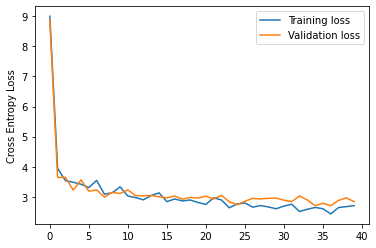

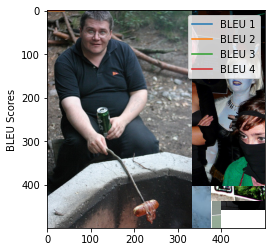

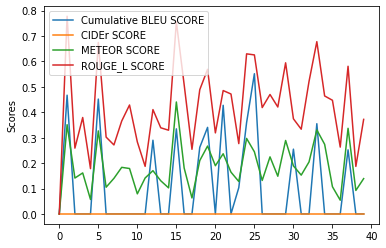

In [26]:
val_iter = iter(val_loader)
train_losses = list()
val_losses = list()
cumulative_bleu_scores = list()
cider_scores = list()
meteor_scores = list()
rougel_scores = list()
bleu1_scores = list()
bleu2_scores = list()
bleu3_scores = list()
bleu4_scores = list()

for epoch in range(num_epochs):
    
    if (epoch+1) >= 21 and train_CNN == False:
        train_CNN = True
        enc.fine_tune(True)
        
    for batch_idx, (imgs, captions, img_ids) in enumerate(train_loader):
        
        enc.train()
        dec.train()
                
        imgs = imgs.to(device)
        captions = captions.to(device)

        enc_imgs, global_features = enc(imgs)
        outputs = dec(enc_imgs, global_features, captions[:-1], captions[:-1].size(0), device)

        loss = criterion(outputs.reshape(-1, outputs.shape[2]), captions[1:].reshape(-1))
        
                
        optim_enc.zero_grad()
        optim_dec.zero_grad()
        loss.backward()
                
        optim_enc.step()             
        optim_dec.step()

        if batch_idx%600 == 0:
            
            with torch.no_grad():
                
                enc.eval()
                dec.eval()
                
                try:
                    val_imgs, val_captions, val_img_ids = next(val_iter)
                
                except StopIteration:
                    val_iter = iter(val_loader)
                    val_imgs, val_captions, val_img_ids = next(val_iter)
                
                val_imgs = val_imgs.to(device)
                val_captions = val_captions.to(device)

                enc_val_imgs, global_val_features = enc(val_imgs)
                val_outputs = dec(enc_val_imgs, global_val_features, val_captions[:-1], val_captions[:-1].size(0), device)

                val_loss = criterion(val_outputs.reshape(-1, val_outputs.shape[2]), val_captions[1:].reshape(-1))
                
                val_losses.append(val_loss.item())
                train_losses.append(loss.item())
                
                val_img_ids = val_img_ids.squeeze(1).numpy()
                
                r_set = np.arange(batch_size)
                
                np.random.shuffle(r_set)
                
                index = r_set[0]
                
                val_img = val_imgs[index]
                candidate = caption_image_beam(val_img.unsqueeze(0), vocab, enc, dec, device)
                ref_tokens = dict_tokens[val_img_ids[index]]
                cumulative_bleu_score = sentence_bleu(ref_tokens, candidate, weights=(0.25, 0.25, 0.25, 0.25))
                    
                hyp = ' '.join(candidate)
                refs = list()
                    
                for sentence in ref_tokens:
                    ref = ' '.join(sentence)
                    refs.append(ref)
                    
                metrics = compute_individual_metrics(refs, hyp)
                
                np.random.shuffle(refs)
                
                bleu1_scores.append(metrics['Bleu_1'])
                bleu2_scores.append(metrics['Bleu_2'])
                bleu3_scores.append(metrics['Bleu_3'])
                bleu4_scores.append(metrics['Bleu_4'])
                cider_scores.append(metrics['CIDEr'])
                cumulative_bleu_scores.append(cumulative_bleu_score)
                rougel_scores.append(metrics['ROUGE_L'])
                meteor_scores.append(metrics['METEOR'])
                
                pil_img = Image.open(os.path.join('flickr30k_images', idx_imgs[val_img_ids[index]])).convert("RGB")
                plt.imshow(np.asarray(pil_img))
                
                print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{batch_idx+1}/{len(train_loader)}] Training loss: {loss.item()} Validation loss: {val_loss.item()} Cumulative BLEU Score: {cumulative_bleu_score} CIDEr Score: {metrics['CIDEr']} METEOR Score: {metrics['METEOR']} ROUGE_L: {metrics['ROUGE_L']} \n")
                print(f"Ground truth: {refs[0]}\n")
                print(f"Predicted Caption: {hyp}\n\n")
    
        if batch_idx == (len(train_loader) - 1):
            torch.save(enc.state_dict(), f'/kaggle/working/encoder_{freq_threshold}_{batch_size}_{hidden_size}_{epoch+1}.pth')
            torch.save(dec.state_dict(), f'/kaggle/working/decoder_{freq_threshold}_{batch_size}_{hidden_size}_{epoch+1}.pth')
    

plt.figure(0)
plt.plot(train_losses, label = 'Training loss')
plt.plot(val_losses, label = 'Validation loss')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.savefig(f'/kaggle/working/{freq_threshold}_{batch_size}_{hidden_size}_{num_epochs}_losses.png')

plt.figure(1)
plt.plot(bleu1_scores, label = 'BLEU 1')
plt.plot(bleu2_scores, label = 'BLEU 2')
plt.plot(bleu3_scores, label = 'BLEU 3')
plt.plot(bleu4_scores, label = 'BLEU 4')
plt.ylabel('BLEU Scores')
plt.legend()
plt.savefig(f'/kaggle/working/{freq_threshold}_{batch_size}_{hidden_size}_{num_epochs}_bleu_scores.png')
        
plt.figure(2)
plt.plot(cumulative_bleu_scores, label = 'Cumulative BLEU SCORE')
plt.plot(cider_scores, label = 'CIDEr SCORE')
plt.plot(meteor_scores, label = 'METEOR SCORE')
plt.plot(rougel_scores, label = 'ROUGE_L SCORE')
plt.ylabel('Scores')
plt.legend()
plt.savefig(f'/kaggle/working/{freq_threshold}_{batch_size}_{hidden_size}_{num_epochs}_scores.png')